In [ ]:
#!pip install pytorch-metric-learning
#!pip install faiss-cpu

In [ ]:
#!/bin/bash
#!curl -L -o ./avengers-faces-dataset.zip https://www.kaggle.com/api/v1/datasets/download/yasserh/avengers-faces-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 89.5M  100 89.5M    0     0  3778k      0  0:00:24  0:00:24 --:--:-- 3946k


In [ ]:
#!unzip ./avengers-faces-dataset.zip

In [ ]:
#!curl -L -o ./face-recognition-dataset.zip https://www.kaggle.com/api/v1/datasets/download/vasukipatel/face-recognition-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  725M  100  725M    0     0  3825k      0  0:03:14  0:03:14 --:--:-- 4049k2:00 3955k0:03:18  0:02:04  0:01:14 3731k


In [ ]:
#!unzip ./face-recognition-dataset.zip

In [1]:
from tqdm import tqdm
import torch
from torchvision import models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pytorch_metric_learning.utils.inference import InferenceModel, MatchFinder, CosineSimilarity
import torch.optim as optim
from pytorch_metric_learning import losses
import pandas as pd

In [2]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torch
import pandas as pd

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.label_map = self._create_label_map()

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label_str = self.img_labels.iloc[idx, 1]
        # label = torch.tensor(self.label_map[label_str])
        label = self.label_map[label_str]


        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def _create_label_map(self):
        unique_labels = self.img_labels.iloc[:, 1].unique()
        return {label: i for i, label in enumerate(unique_labels)}

    def get_label_map(self):
        return self.label_map

In [3]:
N_CLASSES = 31

In [4]:
#loss_func = losses.TripletMarginLoss()

from pytorch_metric_learning.losses import ArcFaceLoss
#loss_func = ArcFaceLoss(num_classes=N_CLASSES, embedding_size=128)
loss_func = ArcFaceLoss(num_classes=N_CLASSES, embedding_size=2048)


In [5]:
# data_dir = './images/train' # marvel 

# transform = models.ResNet50_Weights.IMAGENET1K_V1.transforms()
# image_dataset = datasets.ImageFolder(data_dir, transform=transform)
# dataloader = DataLoader(image_dataset, batch_size=16, shuffle=True)

labels_df = pd.read_csv('./lbl_face.csv')
data_dir = './Faces/Faces'
transform = models.ResNet50_Weights.IMAGENET1K_V1.transforms()
image_dataset = CustomImageDataset(annotations_file=labels_df, img_dir=data_dir, transform=transform)

# Save the label mapping
label_map = image_dataset.get_label_map()
import json
with open('label_map.json', 'w') as f:
    json.dump(label_map, f)

dataloader = DataLoader(image_dataset, batch_size=32, shuffle=True)

In [6]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

In [7]:
#model = torch.nn.Sequential(*(list(model.children())[:-1]))
#model.add_module("flatten", torch.nn.Flatten())

model = torch.nn.Sequential(
    *(list(model.children())[:-1]),
    torch.nn.Flatten(),
    torch.nn.Linear(2048, 128),  # learnable embedding layer
    torch.nn.BatchNorm1d(128),   # often improves metric learning
)

In [8]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [9]:
device = torch.device('cuda')
model = model.to(device)

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [ ]:
model.train()
for epoch in range(50):
	for i, (data, labels) in tqdm(enumerate(dataloader)):
		data, labels = data.to(device), labels.to(device)
		optimizer.zero_grad()
		embeddings = model(data)
		loss = loss_func(embeddings, labels)
		loss.backward()
		optimizer.step()
	print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    

In [ ]:
torch.save(model.state_dict(), 'face_recognition_model_weights_epoch50_fc.pth.pth')

In [12]:
model.load_state_dict(torch.load('face_recognition_model_weights_epoch50_fc.pth'))

<All keys matched successfully>

In [13]:
model.eval()
InferenceModel(model,
                embedder=None,
                match_finder=MatchFinder(distance=CosineSimilarity(), threshold=0.9),
                normalize_embeddings=True,
                knn_func=None,
                data_device=None,
                dtype=None)

In [ ]:
# initialize with a model
im = InferenceModel(model)

# pass in a dataset to serve as the search space for k-nn
im.train_knn(image_dataset)

/home/sciro/anaconda3/envs/superhome/lib/python3.8/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


In [15]:
QUERY_INDEX = 0

In [16]:
query = image_dataset[QUERY_INDEX][0]
query = query.unsqueeze(0)

# get the 10 nearest neighbors of a query
distances, indices = im.get_nearest_neighbors(query, k=30)

# determine if inputs are close to each other
#is_match = im.is_match(x, y)

# determine "is_match" pairwise for all elements in a batch
#match_matrix = im.get_matches(x)

# save and load the knn function (which is a faiss index by default)
#im.save_knn_func("filename.index")
#im.load_knn_func("filename.index")

In [15]:
len(image_dataset)

2562

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


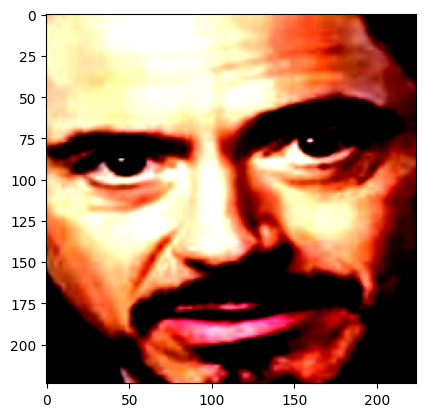

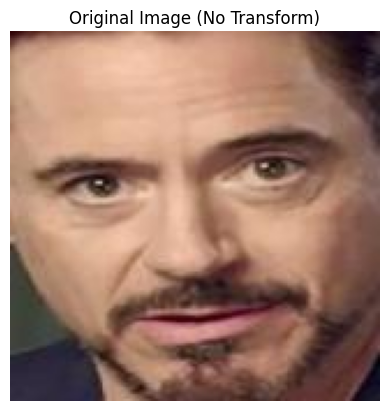

In [17]:
import matplotlib.pyplot as plt
plt.imshow(image_dataset[QUERY_INDEX][0].permute(1, 2, 0))

from PIL import Image
img_path = os.path.join(data_dir, labels_df.iloc[QUERY_INDEX, 0])
img = Image.open(img_path).convert("RGB")
plt.figure()
plt.imshow(img)
plt.title("Original Image (No Transform)")
plt.axis('off')
plt.show()

In [19]:
indices

tensor([[  0,  38, 236, 191,  39, 213,  12, 209,  89,  80]], device='cuda:0')

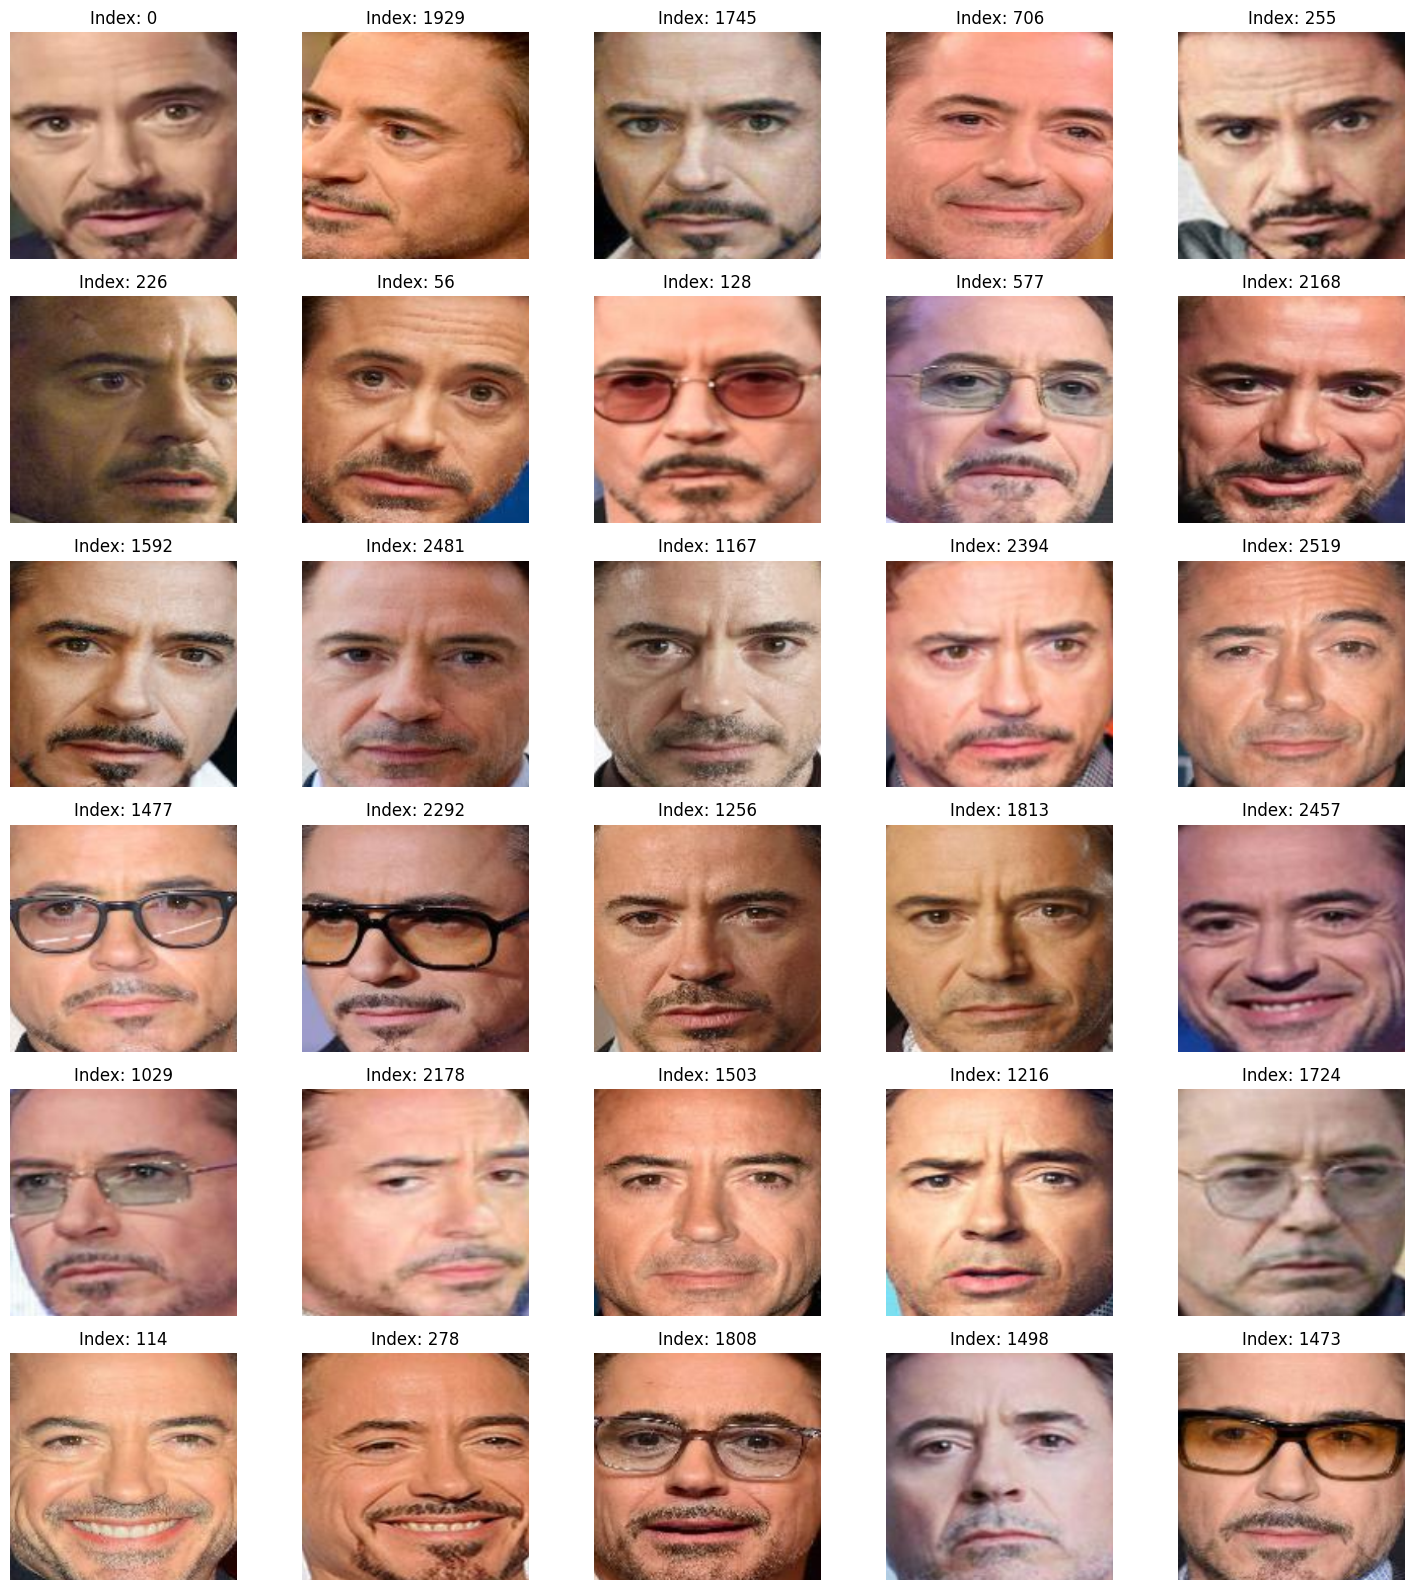

In [18]:
import matplotlib.pyplot as plt

def inverse_transform(img_tensor):
    # Inverse normalization for ImageNet
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor.clone().cpu()
    img = img * std + mean
    img = img.clamp(0, 1)
    return img

fig, axes = plt.subplots(6, 5, figsize=(15, 16))
axes = axes.flatten()

for idx, ax in zip(indices[0].tolist(), axes):
    img_tensor = image_dataset[idx][0]
    img = inverse_transform(img_tensor).permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Index: {idx}')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

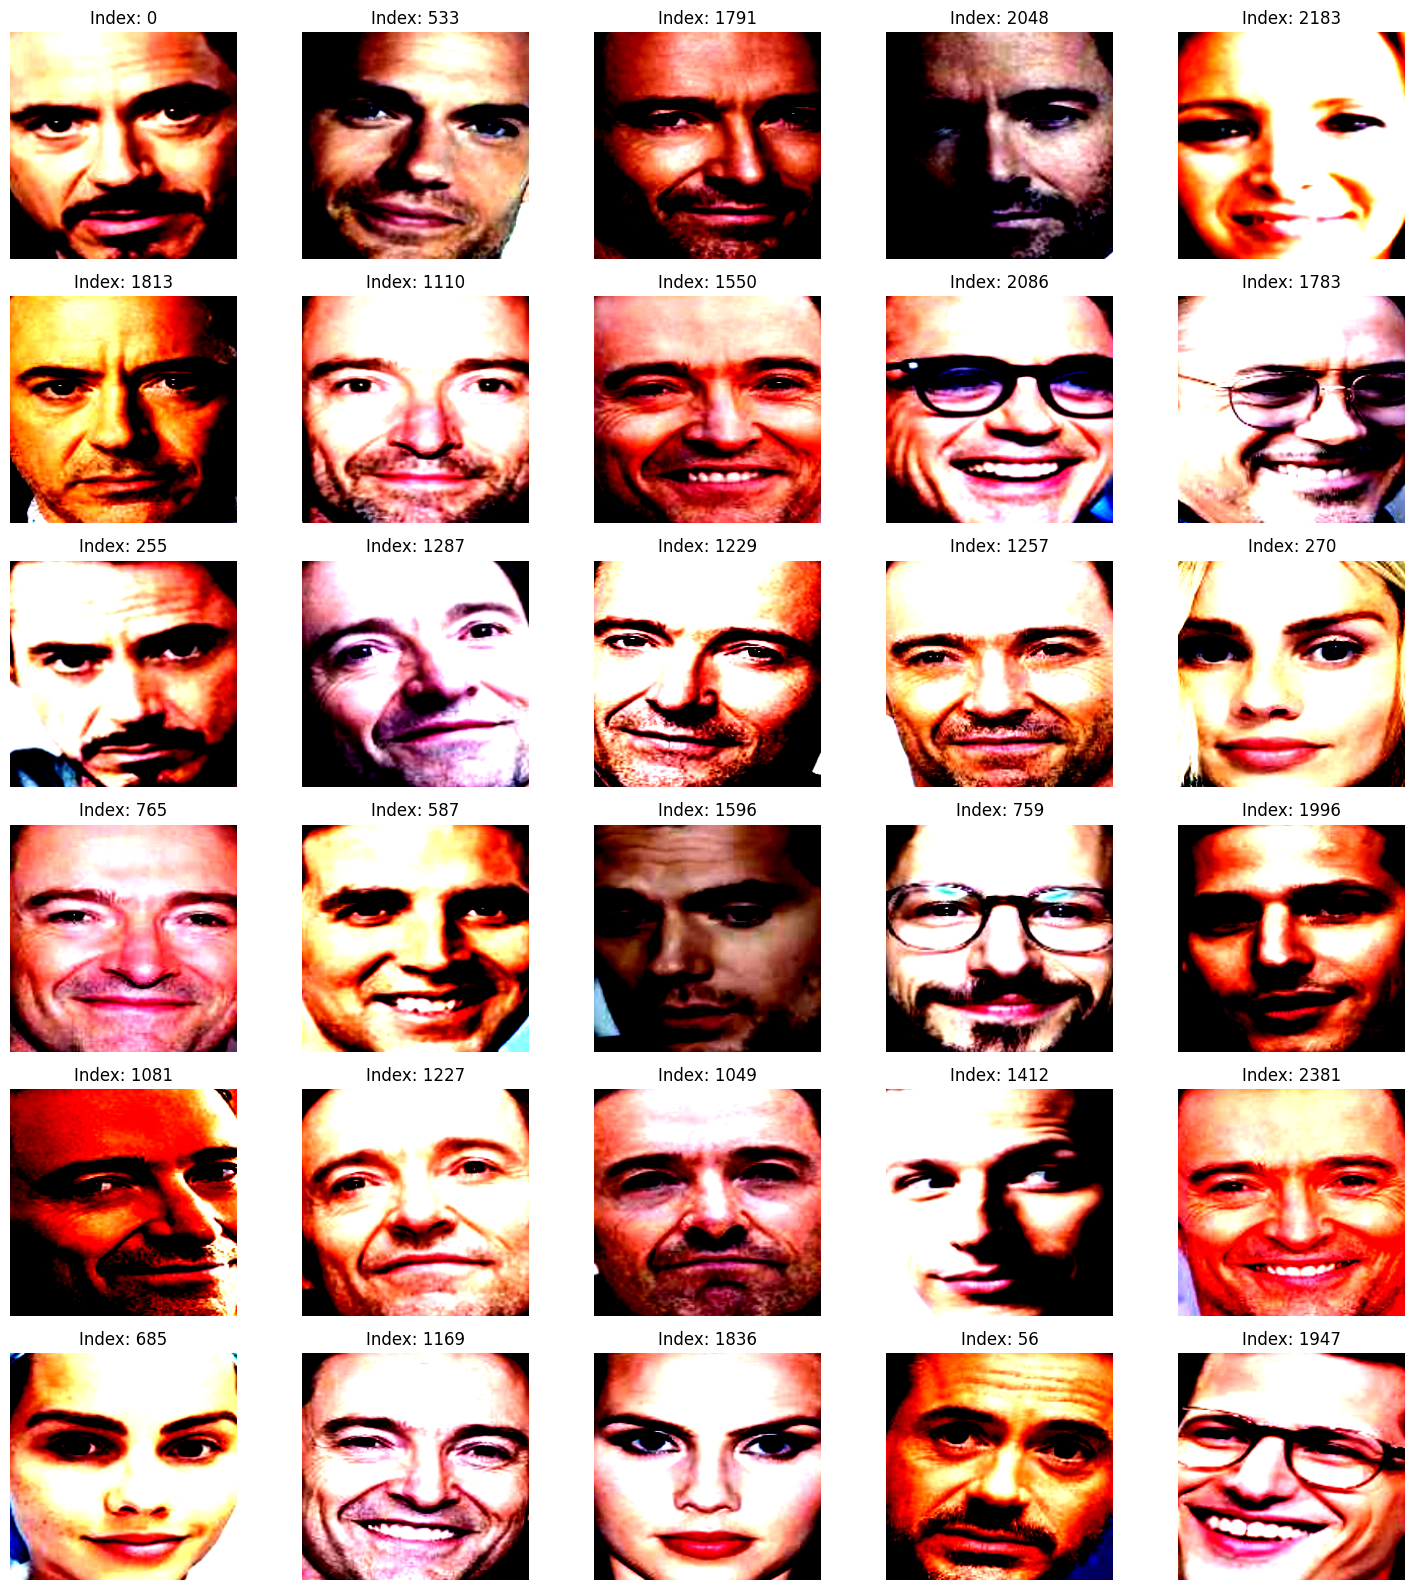

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 5, figsize=(15, 16))
axes = axes.flatten()

for idx, ax in zip(indices[0].tolist(), axes):
    img = image_dataset[idx][0].permute(1, 2, 0).cpu().numpy()
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Index: {idx}')

plt.tight_layout()
plt.show()

In [23]:
distances

tensor([[1.1884e-11, 1.1001e+00, 1.1164e+00, 1.1246e+00, 1.1412e+00, 1.1415e+00,
         1.1455e+00, 1.1461e+00, 1.1521e+00, 1.1630e+00, 1.1684e+00, 1.1769e+00,
         1.1919e+00, 1.2055e+00, 1.2138e+00, 1.2229e+00, 1.2237e+00, 1.2303e+00,
         1.2360e+00, 1.2444e+00, 1.2481e+00, 1.2483e+00, 1.2600e+00, 1.2736e+00,
         1.2742e+00, 1.2821e+00, 1.2869e+00, 1.2908e+00, 1.2960e+00, 1.2982e+00]],
       device='cuda:0')